# Import needed modules

In [1]:
pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nibabel as nib
import os
import itertools
import numpy as np
from nilearn import plotting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read one NIFTI file

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

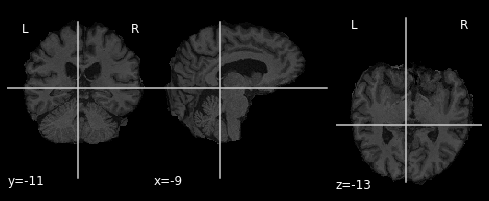

In [4]:
def read_nifti_file1(nifti_file):
    nii_image = nib.load(nifti_file)
    nii_data = nii_image.get_fdata()
    plotting.plot_anat(nii_image)
    return nii_data

read_nifti_file1(r"/content/drive/MyDrive/Data/6389_Data_project1/Training/health/sub6/T1_bet_2_0413.nii.gz")

In [5]:
def read_nifti_file(nifti_file):
    nii_image = nib.load(nifti_file)
    nii_data = nii_image.get_fdata()
    return nii_data

def resize_data(data):
    initial_size_x = data.shape[0]
    initial_size_y = data.shape[1]
    initial_size_z = data.shape[2]

    new_size_x = 128
    new_size_y = 128
    new_size_z = 64
    
    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_data[x][y][z] = data[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_data

def get_data(dtype = "Training" ,resize = True):
    
    healthy_subjects = []
    ad_patients = []
    
    if dtype == "Training":
        for i in range(1,11):
            healthy = read_nifti_file("/content/drive/MyDrive/Data/6389_Data_project1/"+dtype+"/health/sub"+str(i)+"/T1_bet_2_0413.nii.gz")
            patient = read_nifti_file("/content/drive/MyDrive/Data/6389_Data_project1/"+dtype+"/patient/sub"+str(i)+"/T1_bet_2_0413.nii.gz")
            if resize == True:
                healthy = resize_data(healthy)
                patient = resize_data(patient)

            healthy_subjects.append(healthy)
            ad_patients.append(patient)
    
    elif dtype == "Testing":
        for i in range(1,6):
            healthy = read_nifti_file("/content/drive/MyDrive/Data/6389_Data_project1/"+dtype+"/health/sub"+str(i)+"/T1_bet_2_0413.nii.gz")
            patient = read_nifti_file("/content/drive/MyDrive/Data/6389_Data_project1/"+dtype+"/patient/sub"+str(i)+"/T1_bet_2_0413.nii.gz")
            if resize == True:
                healthy = resize_data(healthy)
                patient = resize_data(patient)

            healthy_subjects.append(healthy)
            ad_patients.append(patient)
        
    return healthy_subjects,ad_patients

In [6]:
def flip_image(image):
    flipped_image = tf.image.flip_left_right(image)
    return flipped_image

def augmentation(list_of_data, count = 4):
    
    augmentated_data = list_of_data[:]
    indexes = np.arange(len(list_of_data))
    select_images = np.random.choice(indexes, count+1, replace = False)
    
    # Flipping random count number of images and appending it to the dataset  
    for i in select_images:
        augmentated_data.append(flip_image(list_of_data[i]))
    return augmentated_data

def data_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label

In [7]:
def get_model(width=128, height=128, depth=64):
    #Building a 3D convolutional neural network model.
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Defining the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [8]:
# Get data and apply augmentation
healthy_subjects, patients = get_data(resize = True)

### Method 1: Using the resized images on model 

In [9]:
print("Number of MRI healthy subjects: " + str(len(healthy_subjects)))
print("Number of MRI un-healthy subjects: " + str(len(patients)))

Number of MRI healthy subjects: 10
Number of MRI un-healthy subjects: 10


In [10]:
# Assigning class labels
abnormal_labels = np.array([1 for _ in range(len(patients))])
normal_labels = np.array([0 for _ in range(len(healthy_subjects))])

x_train = []
y_train = []

x_train.extend(healthy_subjects)
x_train.extend(patients)
y_train.extend(normal_labels)
y_train.extend(abnormal_labels)

print("Number of samples in train are %d."% (len(x_train)))

Number of samples in train are 20.


In [11]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(data_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [12]:
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [13]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)


In [14]:
epochs = 10

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

history = model.fit(
    train_dataset,
    epochs=epochs,
    shuffle=True,
)

Epoch 1/10
10/10 [==============================] - 230s 23s/step - loss: 0.8941 - acc: 0.7500
Epoch 2/10
10/10 [==============================] - 227s 23s/step - loss: 0.6697 - acc: 0.7000
Epoch 3/10
10/10 [==============================] - 232s 23s/step - loss: 0.7513 - acc: 0.5500
Epoch 4/10
10/10 [==============================] - 229s 23s/step - loss: 0.6224 - acc: 0.7000
Epoch 5/10
10/10 [==============================] - 227s 23s/step - loss: 0.5173 - acc: 0.7000
Epoch 6/10
10/10 [==============================] - 230s 23s/step - loss: 0.6200 - acc: 0.7000
Epoch 7/10
10/10 [==============================] - 227s 23s/step - loss: 0.6145 - acc: 0.7000
Epoch 8/10
10/10 [==============================] - 228s 23s/step - loss: 0.5081 - acc: 0.7000
Epoch 9/10
10/10 [==============================] - 227s 23s/step - loss: 0.5885 - acc: 0.6000
Epoch 10/10
10/10 [==============================] - 230s 23s/step - loss: 0.6967 - acc: 0.5500


In [15]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [16]:
sum(history.history['acc'])/len(history.history['acc']) # Avergae accuracy

0.6649999976158142

In [17]:
# Creating Validation Data set
test_h, test_p = get_data("Testing", resize = True)
test_abnormal_labels = np.array([1 for _ in range(len(test_p))])
test_normal_labels = np.array([1 for _ in range(len(test_h))])

In [18]:
x_test = []
y_test = []

x_test.extend(test_h)
x_test.extend(test_p)
y_test.extend(test_normal_labels)
y_test.extend(test_abnormal_labels)

In [19]:
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(data_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [20]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

5/5 - 15s - loss: 0.2357 - acc: 1.0000 - 15s/epoch - 3s/step


In [21]:
test_acc

1.0

### Method 2: Data Augmentation & Resizing

In [22]:
# call the augmentation function

# Adding 6 images from healthy as well as patient dataset
augemented_healthy_subjects = augmentation(healthy_subjects, count = 6)
augemented_patients = augmentation(patients, count = 6)

print("Number of MRI healthy subjects: " + str(len(augemented_healthy_subjects)))
print("Number of MRI un-healthy subjects: " + str(len(augemented_patients)))

Number of MRI healthy subjects: 17
Number of MRI un-healthy subjects: 17


In [23]:
abnormal_labels2 = np.array([1 for _ in range(len(augemented_patients))])
normal_labels2 = np.array([0 for _ in range(len(augemented_healthy_subjects))])

x_train2 = []
y_train2 = []

x_train2.extend(augemented_healthy_subjects)
x_train2.extend(augemented_patients)
y_train2.extend(normal_labels2)
y_train2.extend(abnormal_labels2)

print("Number of samples in train are %d."% (len(x_train2)))

Number of samples in train are 34.


In [24]:
train_loader2 = tf.data.Dataset.from_tensor_slices((x_train2, y_train2))
batch_size = 2
train_dataset2 = (
    train_loader.shuffle(len(x_train))
    .map(data_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [25]:
model2 = get_model()
model2.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [26]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model2.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)


In [27]:
epochs = 5

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

history2 = model2.fit(
    train_dataset2,
#     validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
)

Epoch 1/5
10/10 [==============================] - 237s 23s/step - loss: 1.2583 - acc: 0.5500
Epoch 2/5
10/10 [==============================] - 232s 23s/step - loss: 0.6525 - acc: 0.6000
Epoch 3/5
10/10 [==============================] - 230s 23s/step - loss: 0.6370 - acc: 0.6500
Epoch 4/5
10/10 [==============================] - 229s 23s/step - loss: 0.7625 - acc: 0.7000
Epoch 5/5
10/10 [==============================] - 227s 23s/step - loss: 0.7230 - acc: 0.6000


In [28]:
test_loss2, test_acc2 = model2.evaluate(test_dataset, verbose=2) # Testing against Validation

5/5 - 14s - loss: 0.0309 - acc: 1.0000 - 14s/epoch - 3s/step


In [29]:
sum(history.history['acc'])/len(history.history['acc']) # Average Accuracy

0.6649999976158142